In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import zipfile
import os
from google.colab import files

In [ ]:
# Set device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile

zip_path = "/content/drive/My Drive/asl_alphabet_train.zip"
extract_to = "/content/asl_alphabet_train"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


In [ ]:
# Data preprocessingg
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
from torchvision import datasets, transforms
dataset = datasets.ImageFolder("/content/asl_alphabet_train/asl_alphabet_train", transform=train_transform)


In [ ]:
from torch.utils.data import DataLoader
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#4Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
print("Classes:", dataset.classes)
class_names = dataset.classes
print("Detected classes:", class_names)
print("Classes found:", dataset.classes)
print("Number of classes:", len(dataset.classes))


Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Detected classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Classes found: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Number of classes: 29


In [ ]:
#Define CNN Model
class ASLClassifier(nn.Module):
    def __init__(self):
        super(ASLClassifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, len(class_names))
        )

    def forward(self, x):
        return self.fc(self.conv(x))

model = ASLClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
#Train & Evaluate Functions
def train(model, loader):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

In [ ]:
#Train the Model
epochs = 15
for epoch in range(epochs):
    loss = train (model, train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

Epoch 1/15, Loss: 1.4419
Epoch 2/15, Loss: 0.5284
Epoch 3/15, Loss: 0.3451
Epoch 4/15, Loss: 0.2587
Epoch 5/15, Loss: 0.2100
Epoch 6/15, Loss: 0.1845
Epoch 7/15, Loss: 0.1672
Epoch 8/15, Loss: 0.1458
Epoch 9/15, Loss: 0.1396
Epoch 10/15, Loss: 0.1325
Epoch 11/15, Loss: 0.1202
Epoch 12/15, Loss: 0.1228
Epoch 13/15, Loss: 0.1084
Epoch 14/15, Loss: 0.1111
Epoch 15/15, Loss: 0.0992


In [ ]:
#Evaluate on validation set
val_true, val_pred = evaluate(model, val_loader)

from sklearn.metrics import classification_report
print("\nValidation Performance:")
print(classification_report(val_true, val_pred, target_names=class_names))


Validation Performance:
              precision    recall  f1-score   support

           A       0.99      0.97      0.98       628
           B       0.99      0.98      0.99       577
           C       1.00      1.00      1.00       581
           D       0.99      0.99      0.99       597
           E       0.97      0.97      0.97       636
           F       1.00      1.00      1.00       634
           G       0.99      0.97      0.98       602
           H       0.97      0.99      0.98       596
           I       0.97      1.00      0.98       609
           J       0.99      0.99      0.99       599
           K       0.99      0.98      0.99       599
           L       1.00      0.99      1.00       566
           M       0.99      0.96      0.97       579
           N       0.96      0.99      0.98       591
           O       1.00      0.99      1.00       640
           P       0.99      0.99      0.99       600
           Q       0.99      1.00      0.99       592
  

In [ ]:
zip_path = "/content/drive/MyDrive/asl_alphabet_test.zip"
extract_to = "/content/asl_alphabet_test/asl_alphabet_test"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
print("Extracted to:", extract_to)
from PIL import Image
test_images = []
test_labels = []
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

for filename in os.listdir(extract_to):
    if filename.endswith(".jpg"):
        label_char = filename.split("_")[0]
        label = class_to_idx.get(label_char)
        if label is None:
            continue
        image_path = os.path.join(extract_to, filename)
        image = Image.open(image_path).convert('RGB')
        image_tensor = test_transform(image)
        test_images.append(image_tensor)
        test_labels.append(label)

test_images = torch.stack(test_images).to(device)
test_labels = torch.tensor(test_labels).to(device)

print("Test images:", test_images.shape)
print("Test labels:", test_labels)

Extracted to: /content/asl_alphabet_test/asl_alphabet_test
Test images: torch.Size([28, 3, 224, 224])
Test labels: tensor([15,  2, 27, 24, 16,  9,  1, 19, 28, 14,  8, 21,  0, 12, 17,  6, 13,  3,
        25, 10,  4, 11, 20,  7, 22, 18, 23,  5], device='cuda:0')


In [ ]:
del_index = class_names.index("del")
unique_test_indices = np.unique(test_labels.cpu().numpy())
filtered_class_names = [class_names[i] for i in unique_test_indices]

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)
test_true = test_labels.cpu().numpy()
print("\nTest Set Performance (28 classes only):")
print(classification_report(test_true, test_pred, target_names=filtered_class_names))

#metrics
accuracy = accuracy_score(test_true, test_pred)
precision = precision_score(test_true, test_pred, average='macro')
recall = recall_score(test_true, test_pred, average='macro')
f1 = f1_score(test_true, test_pred, average='macro')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")



Test Set Performance (28 classes only):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         1
           F       1.00      1.00      1.00         1
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         1
           L       1.00      1.00      1.00         1
           M       1.00      1.00      1.00         1
           N       1.00      1.00      1.00         1
           O       1.00      1.00      1.00         1
           P       1.00      1.00      1.00         1
           Q       1.00      1.00      1

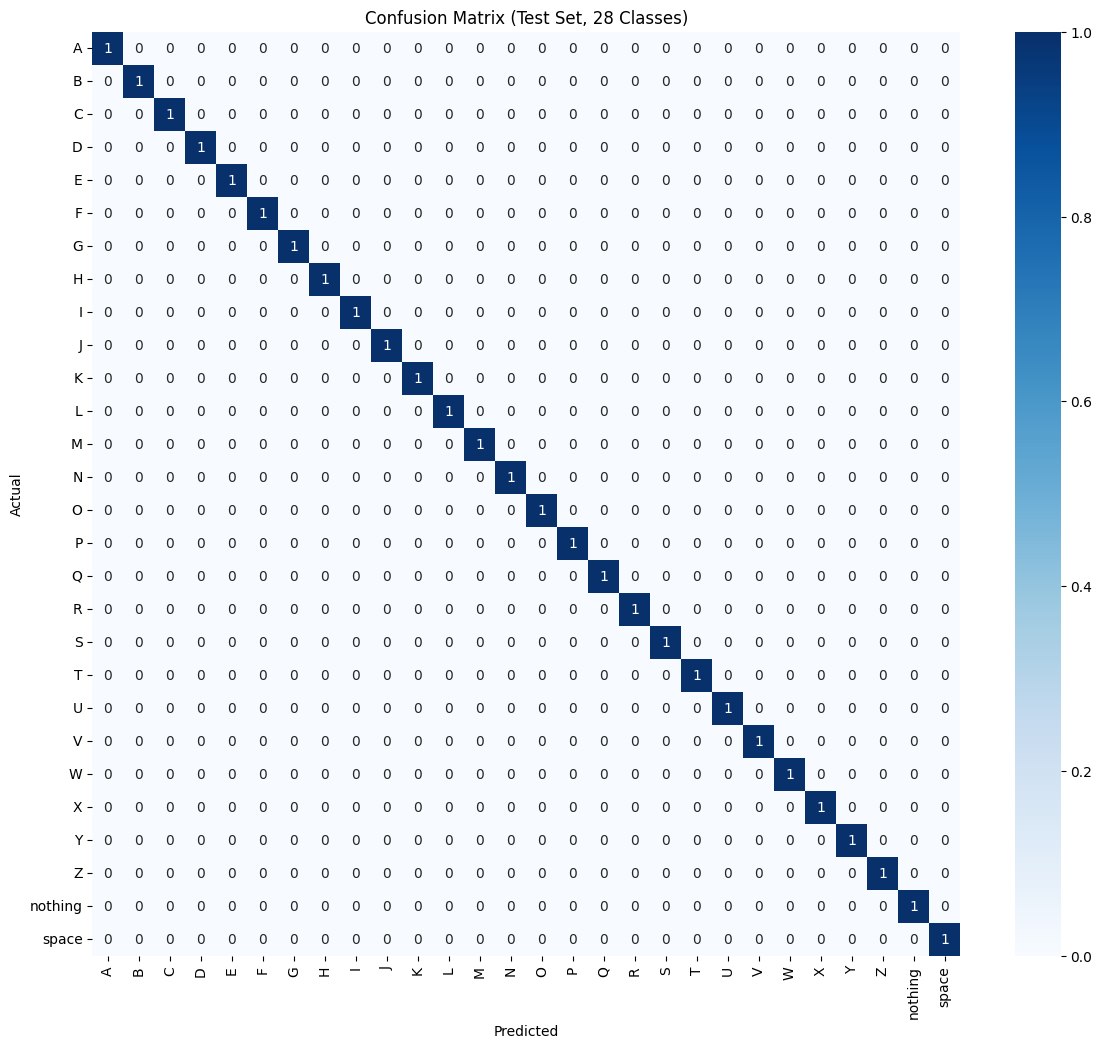

In [ ]:
#confusion matrix
conf_mat = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues",
            xticklabels=filtered_class_names, yticklabels=filtered_class_names)
plt.title("Confusion Matrix (Test Set, 28 Classes)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
